In [103]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [104]:
results_dir = os.path.join("results")

In [105]:
totals = {
    "nils": 14856,
    "entities_found": 71500,
    "entities_not_found": 23528,
    "generic_types": 96,
    "specific_types": 774,
    "acronyms": 3518,
    "typos": 12135,
    "alias": 7117,
    "single_domain": 435,
    "multi_domain": 435,
    "small_per_cols": 152,
    "medium_per_cols": 465,
    "large_per_cols": 253,
    "small_per_rows": 394,
    "medium_per_rows": 232,
    "large_per_rows": 244,
    "total_tables": 870,
    "total_rows": 37820,
    "total_cols": 5252,
    "total_cells": 133137,
}
totals = pd.DataFrame.from_dict(totals, orient="index", columns=["challenge_total"]).reset_index(names="challenge")
print(totals)

             challenge  challenge_total
0                 nils            14856
1       entities_found            71500
2   entities_not_found            23528
3        generic_types               96
4       specific_types              774
5             acronyms             3518
6                typos            12135
7                alias             7117
8        single_domain              435
9         multi_domain              435
10      small_per_cols              152
11     medium_per_cols              465
12      large_per_cols              253
13      small_per_rows              394
14     medium_per_rows              232
15      large_per_rows              244
16        total_tables              870
17          total_rows            37820
18          total_cols             5252
19         total_cells           133137


In [106]:
annotable_prompts = json.load(open(os.path.join(results_dir, "annotable_prompts.json")))
annotable_prompts = pd.DataFrame(annotable_prompts)
annotable_prompts = annotable_prompts.rename(columns={"model": "model_name"})
annotable_prompts["model_name"] = annotable_prompts["model_name"].apply(
    lambda x: x.split("/")[-1]
)
annotable_prompts.head()

,model_name,max_context,total_prompts,out_of_context_prompts,annotable_prompts
0,gemma-2-2b,8192,84907,142,84765
1,Phi-3-mini-4k-instruct,4096,84907,3944,80963
2,Phi-3-mini-128k-instruct,131072,84907,0,84907
3,Llama-3.2-1B,131072,84907,0,84907
4,Llama-3.2-3B,131072,84907,0,84907


In [107]:
overall_results = []
per_challenge_results = []
overall_columns = ["model_name", "total_time", "accuracy", "total_correct", "ne_cells"]
columns_to_exlude = ["system", "machine", "processor", "cuda"]

for filename in os.listdir(results_dir):
    if filename.endswith(".json") and not filename.startswith("annotable_prompts"):
        print(filename)
        data = json.load(open(os.path.join(results_dir, filename)))
        data.pop("final_stats")
        for k, v in data.pop("stats").items():
            data[k] = v
        data["model_name"] = data["model_name"].split("/")[-1]

        data = pd.DataFrame.from_dict(data, orient="index").T
        data = data.melt(id_vars=["model_name"])

        overall_data = (
            data[data["variable"].isin(overall_columns)]
            .pivot(columns="variable", values="value", index="model_name")
            .reset_index()
        )
        overall_data = overall_data.merge(
            annotable_prompts, on=["model_name"], how="left"
        )
        overall_results.append(overall_data)

        data = data[~data["variable"].isin(overall_columns + columns_to_exlude)]
        data = data.merge(annotable_prompts, on=["model_name"], how="left")
        data = data.rename(columns={"variable": "challenge", "value": "correct"})
        try:
            data["total"] = data.apply(
                lambda x: totals[totals["challenge"] == x["challenge"]][
                    "challenge_total"
                ].values[0],
                axis=1,
            )
        except Exception:
            print(filename)
        data["accuracy"] = data["correct"] / data["total"]
        per_challenge_results.append(data)

overall_results = pd.concat(overall_results, ignore_index=True).reset_index()
per_challenge_results = pd.concat(
    per_challenge_results, ignore_index=True
).reset_index()

Llama-3.2-1B.json
Llama-3.2-3B.json
Yi-1.5-6B.json
Phi-3-mini-4k-instruct.json
Qwen2.5-7B.json
Qwen2.5-0.5B.json
Falcon3-7B-Instruct.json
Qwen2-1.5B.json
Phi-3-small-8k-instruct.json
Yi-1.5-9B.json
Phi-3-mini-128k-instruct.json
Qwen2-7B.json
Qwen2-0.5B.json
gemma-2-2b-it.json
gemma-2-9b-it.json
meta-llama-3.1-8b-instruct.json


In [108]:
overall_results.sort_values(by=["accuracy"], ascending=[True], inplace=True)

In [109]:
overall_results

,index,model_name,accuracy,ne_cells,total_correct,total_time,max_context,total_prompts,out_of_context_prompts,annotable_prompts
5,5,Qwen2.5-0.5B,0.015,84907,1329,51666.95,32768.0,84907.0,0.0,84907.0
12,12,Qwen2-0.5B,0.044,84907,3741,52659.894,131072.0,84907.0,0.0,84907.0
0,0,Llama-3.2-1B,0.048,84907,4142,83214.818,131072.0,84907.0,0.0,84907.0
2,2,Yi-1.5-6B,0.068,84907,5832,187070.847,4096.0,84907.0,3543.0,81364.0
7,7,Qwen2-1.5B,0.166,84907,14124,98496.646,131072.0,84907.0,0.0,84907.0
9,9,Yi-1.5-9B,0.177,84907,15080,277928.323,NaN,NaN,NaN,NaN
6,6,Falcon3-7B-Instruct,0.276,84907,23508,66890.43,NaN,NaN,NaN,NaN
3,3,Phi-3-mini-4k-instruct,0.281,84907,23881,369925.491,4096.0,84907.0,3944.0,80963.0
10,10,Phi-3-mini-128k-instruct,0.285,84907,24247,401400.957,131072.0,84907.0,0.0,84907.0
11,11,Qwen2-7B,0.289,84907,24546,283404.264,NaN,NaN,NaN,NaN


In [110]:
per_challenge_results

,index,model_name,challenge,correct,max_context,total_prompts,out_of_context_prompts,annotable_prompts,total,accuracy
0,0,Llama-3.2-1B,nils,1625,131072.0,84907.0,0.0,84907.0,14856,0.109383
1,1,Llama-3.2-1B,acronyms,30,131072.0,84907.0,0.0,84907.0,3518,0.008528
2,2,Llama-3.2-1B,typos,98,131072.0,84907.0,0.0,84907.0,12135,0.008076
3,3,Llama-3.2-1B,alias,60,131072.0,84907.0,0.0,84907.0,7117,0.008431
4,4,Llama-3.2-1B,generic_types,4,131072.0,84907.0,0.0,84907.0,96,0.041667
...,...,...,...,...,...,...,...,...,...,...
219,219,meta-llama-3.1-8b-instruct,medium_per_cols,321,NaN,NaN,NaN,NaN,465,0.690323
220,220,meta-llama-3.1-8b-instruct,large_per_cols,180,NaN,NaN,NaN,NaN,253,0.711462
221,221,meta-llama-3.1-8b-instruct,small_per_rows,245,NaN,NaN,NaN,NaN,394,0.621827
222,222,meta-llama-3.1-8b-instruct,medium_per_rows,166,NaN,NaN,NaN,NaN,232,0.715517


In [111]:
# Define base colors for each model family
model_families = {
    "Qwen": "#3366CC",  # Blue family
    "Llama": "#DC3912",  # Red family
    "Phi": "#109618",  # Green family
    "Yi": "#FF9900",  # Orange family
    "gemma": "#990099",  # Purple family
    "Falcon": "#0099C6",  # Teal family
    "meta": "#DD4477",  # Pink family
}

# Identify all models in each family
family_models = {}
for model in overall_results["model_name"]:
    for family in model_families:
        if family.lower() in model.lower():
            if family not in family_models:
                family_models[family] = []
            family_models[family].append(model)
            break

# Create a palette mapping each model to its color
palette = {}
for family, models in family_models.items():
    # Sort models by accuracy within each family
    sorted_models = sorted(
        models,
        key=lambda x: overall_results[overall_results["model_name"] == x][
            "accuracy"
        ].values[0],
    )
    # Create different brightness levels based on accuracy ranking
    shades = sns.light_palette(model_families[family], n_colors=len(models) + 2)[1:-1]
    # Assign each model a shade
    for i, model in enumerate(sorted_models):
        palette[model] = shades[i]

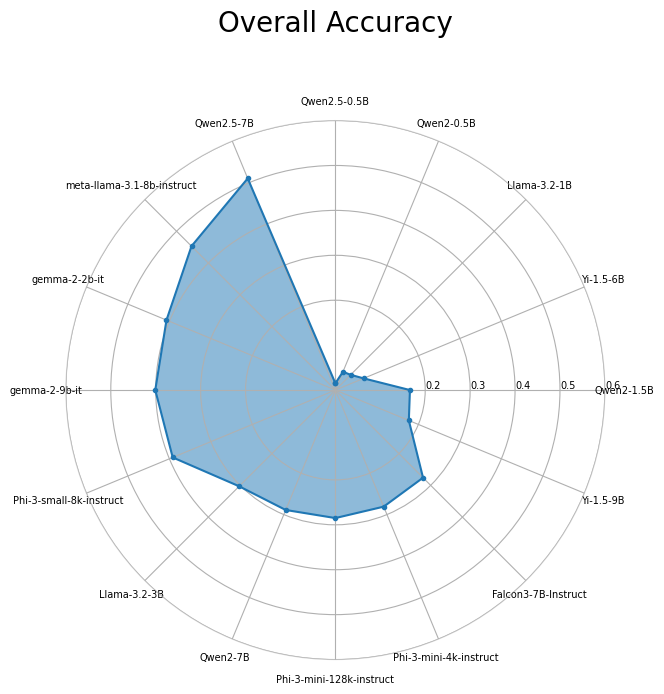

In [112]:
def plot_radar_chart(data, metrics, title):
    N = len(data)
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    theta = np.concatenate([theta, [theta[0]]])

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": "polar"})
    ax.set_title(title, y=1.15, fontsize=20)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(90)
    ax.spines["polar"].set_zorder(1)
    ax.spines["polar"].set_color("lightgrey")

    # color_palette = ["#339F00", "#0500FF", "#9CDADB", "#FF00DE", "#FF9900", "#FFFFFF"]

    values = data[metrics].values.flatten().tolist()
    values = values + [values[0]]
    ax.plot(theta, values, marker="o", markersize=3)
    ax.fill(theta, values, alpha=0.50)

    plt.xticks(
        theta[:-1],
        data["model_name"].tolist(),
        color="black",
        size=7,
    )
    plt.yticks(
        [0.2, 0.3, 0.4, 0.5, 0.6],
        ["0.2", "0.3", "0.4", "0.5", "0.6"],
        color="black",
        size=7,
    )
    return fig


# Plot
fig = plot_radar_chart(overall_results, ["accuracy"], title="Overall Accuracy")
plt.show()

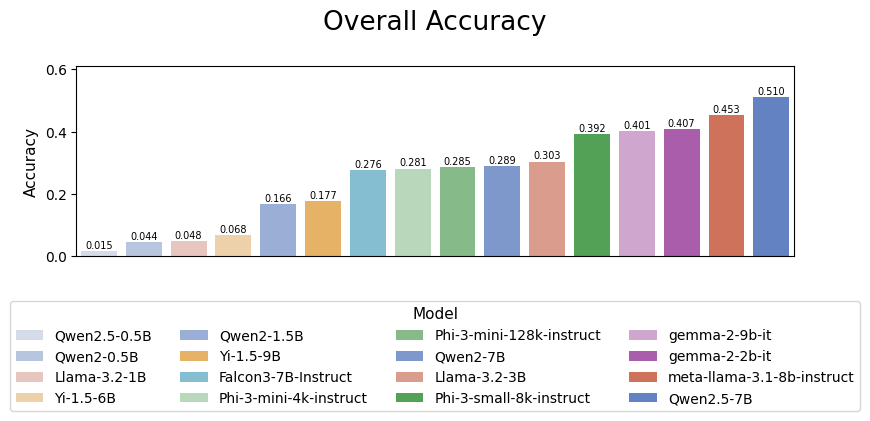

In [113]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_title("Overall Accuracy", y=1.15, fontsize=19)
ax.set_ylabel("Accuracy", fontsize=11)
plt.ylim(0, overall_results["accuracy"].max() + 0.1)
bars = sns.barplot(
    overall_results,
    x="model_name",
    y="accuracy",
    hue=overall_results["model_name"],
    palette=palette,
    legend=True,
    ax=ax,
)
plt.xlabel("")
plt.xticks(ticks=[])
# Adding values over the bars
print(bars.containers[0].patches)
for p in bars.containers:
    p = p.patches[0]
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 0.01,
        f"{height:.3f}",
        ha="center",
        fontsize=7,
    )
sns.move_legend(
    ax,
    "upper center",
    bbox_to_anchor=(0.5, -0.2),
    title="Model",
    fontsize=10,
    title_fontsize=11,
    ncols=4,
)
plt.tight_layout()

In [114]:
per_challenge_results

,index,model_name,challenge,correct,max_context,total_prompts,out_of_context_prompts,annotable_prompts,total,accuracy
0,0,Llama-3.2-1B,nils,1625,131072.0,84907.0,0.0,84907.0,14856,0.109383
1,1,Llama-3.2-1B,acronyms,30,131072.0,84907.0,0.0,84907.0,3518,0.008528
2,2,Llama-3.2-1B,typos,98,131072.0,84907.0,0.0,84907.0,12135,0.008076
3,3,Llama-3.2-1B,alias,60,131072.0,84907.0,0.0,84907.0,7117,0.008431
4,4,Llama-3.2-1B,generic_types,4,131072.0,84907.0,0.0,84907.0,96,0.041667
...,...,...,...,...,...,...,...,...,...,...
219,219,meta-llama-3.1-8b-instruct,medium_per_cols,321,NaN,NaN,NaN,NaN,465,0.690323
220,220,meta-llama-3.1-8b-instruct,large_per_cols,180,NaN,NaN,NaN,NaN,253,0.711462
221,221,meta-llama-3.1-8b-instruct,small_per_rows,245,NaN,NaN,NaN,NaN,394,0.621827
222,222,meta-llama-3.1-8b-instruct,medium_per_rows,166,NaN,NaN,NaN,NaN,232,0.715517


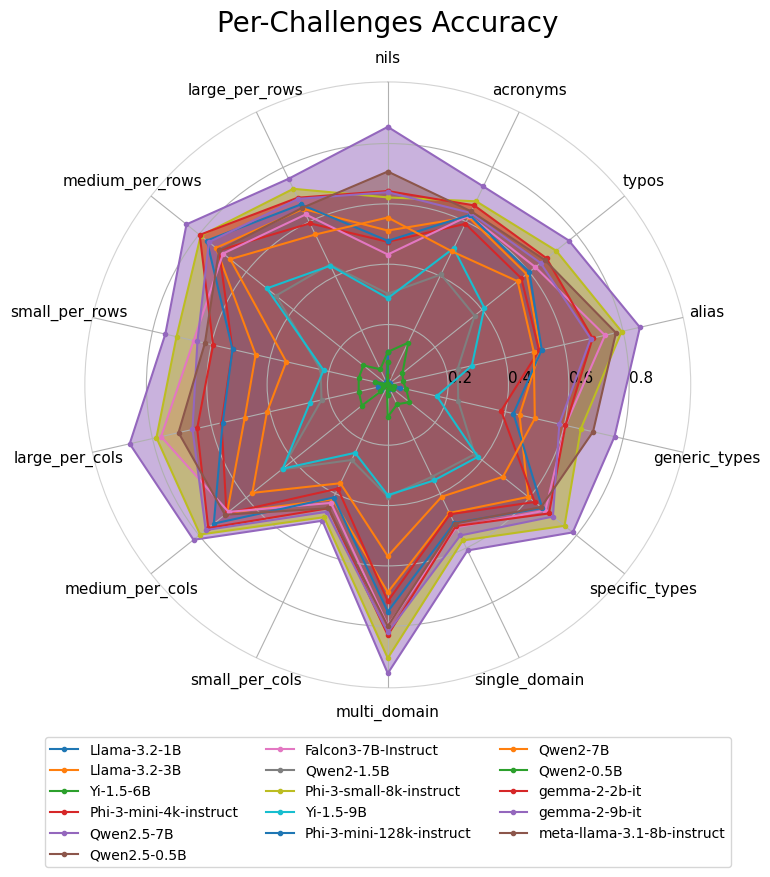

In [115]:
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "polar"})
ax.set_title("Per-Challenges Accuracy", y=1.07, fontsize=20)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlabel_position(90)
ax.spines["polar"].set_zorder(1)
ax.spines["polar"].set_color("lightgrey")

unique_models = per_challenge_results["model_name"].unique().tolist()
unique_challenges = per_challenge_results["challenge"].unique().tolist()
unique_challenges = [challenge for challenge in unique_challenges]

N = len(unique_challenges)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
theta = np.concatenate([theta, [theta[0]]])
for model_name in unique_models:
    values = per_challenge_results[per_challenge_results["model_name"] == model_name][
        "accuracy"
    ].tolist()
    values = values + [values[0]]
    ax.plot(theta, values, marker="o", markersize=3, label=model_name)
    ax.fill(theta, values, alpha=0.50)

    plt.xticks(
        theta[:-1],
        unique_challenges,
        color="black",
        size=11,
    )
    plt.yticks(
        [0.2, 0.4, 0.6, 0.8],
        ["0.2", "0.4", "0.6", "0.8"],
        color="black",
        size=11,
    )
    plt.tick_params(pad=7)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.07), ncols=3)

plt.tight_layout()
plt.show()

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >
 <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]


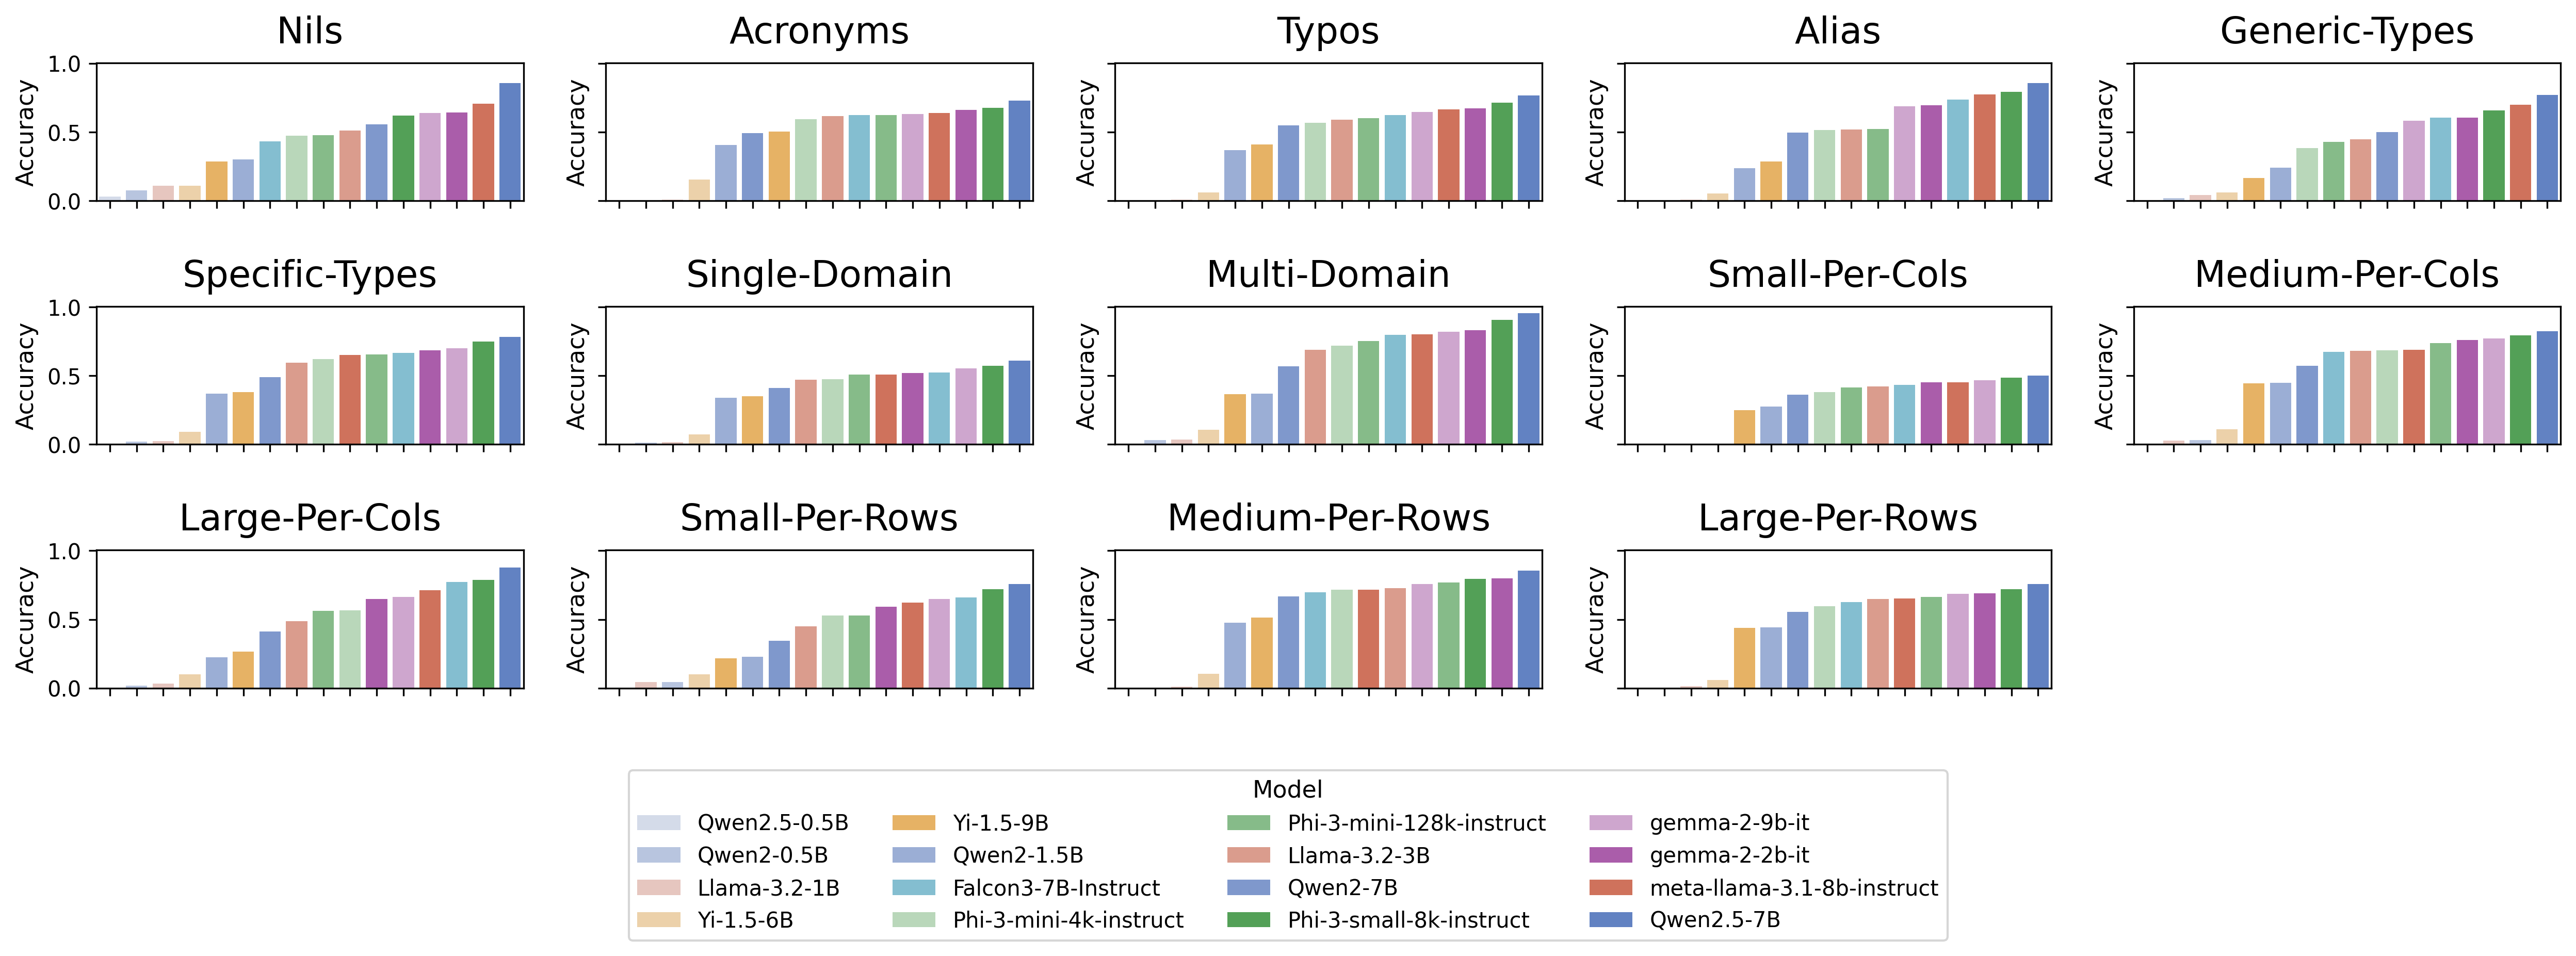

In [166]:
import math

challenges = per_challenge_results["challenge"].unique().tolist()
challenges = [
    challenge
    for challenge in challenges
    # if challenge not in {"alias", "acronyms", "typos"}
]

nrows = 3
ncols = math.ceil(len(challenges) / nrows)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(17, 5),
    sharex=False,
    sharey=True,
    dpi=300
)

# Handle both single row and multi-row cases
axes_flat = axes.flatten() if hasattr(axes, "flatten") else [axes]
print(axes_flat)

unique_model_names = per_challenge_results["model_name"].unique().tolist()
for i, challenge in enumerate(challenges):
    ax = axes_flat[i]
    ax.set_title(challenge.title().replace("_", "-"), y=1.05, fontsize=17)
    ax.set_ylabel("Accuracy", fontsize=11)

    challenge_data = per_challenge_results[
        per_challenge_results["challenge"] == challenge
    ].sort_values(by="accuracy", ascending=True)

    if challenge_data.empty:
        continue

    # 2) plot, *no* hue, but *with* order=…
    sns.barplot(
        data=challenge_data,
        x="model_name",
        y="accuracy",
        palette=palette,
        hue="model_name",
        order=challenge_data["model_name"].tolist(),
        ax=ax,
        legend=True if i == 0 else False,
    )
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
    ax.set_xticklabels([])
    ax.set_xlabel("")

# Hide any empty subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis("off")

# Add legend to figure
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.02),
    ncol=4,
    title="Model",
    fontsize=10,
    title_fontsize=11,
)

plt.tight_layout(pad=2.0)
plt.show()